# Fine-tuning your model
Having trained your model, your next task is to evaluate its performance. What metrics can you use to gauge how good your model is? So far, you have used **accuracy for classification** and **R-squared for regression**. In this chapter, you will learn about some of the other metrics available in scikit-learn that will allow you to assess your model's performance in a more nuanced manner. You will then learn to optimize both your classification as well as regression models using hyperparameter tuning.

## Classification metrics
- Measuring model performance with accuracy:
    - Fraction of correctly classified samples
    - Not always a useful metric

### Class imbalance example: Emails
- Spam classification
    - 99% of emails are real; 1% of emails are spam
- Could build a classifier that predicts ALL emails as real
    - 99% accurate!
    - But horrible at actually classifying spam
    - Fails at its original purpose
- Need more nuanced metrics

### Diagnosing classification predictions
 
- Confusion matrix


 | **Predicted Spam Email** | **Predicted Real Email**|                       |
 |------                    |------                   |-------------------    |
 | True Positive ($tp$)     | False Negative ($fn$)   |**Actual:Spam Email**  |
 | False Positive ($fp$)    | True Negative ($tn$)    |**Actual: Real Email** |
 
 
- $Accuracy =  \frac{tp+tn}{tp+tn+fp+fn}$

### Metrics from the confusion matrix

- $Precision = \frac{tp}{tp+fp}$
- $Recall = \frac{tp}{tp+fn}$ also called True possitive rate
- $F1 score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
- **High precision**: Not many real emails predicted as spam
- **High recall**: Predicted most spam emails correctly

In [1]:
from IPython.display import HTML, Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
%%HTML
<video style="display:block; margin: 0 auto;" controls>
      <source src="_Docs/01-How_good_is_your_model.mp4" type="video/mp4">
</video>

### Metrics for classification
In Chapter 1, you evaluated the performance of your k-NN classifier based on its accuracy. However, as Andy discussed, accuracy is not always an informative metric. In this exercise, you will dive more deeply into evaluating the performance of binary classifiers by computing a confusion matrix and generating a classification report.

You may have noticed in the video that the classification report consisted of three rows, and an additional support column. The support gives the number of samples of the true response that lie in that class - so in the video example, the support was the number of Republicans or Democrats in the test set on which the classification report was computed. The precision, recall, and f1-score columns, then, gave the respective metrics for that particular class.

Here, you'll work with the [PIMA Indians][1] dataset obtained from the UCI Machine Learning Repository. **The goal is to predict whether or not a given female patient will contract diabetes based on features such as BMI, age, and number of pregnancies**. Therefore, it is a binary classification problem. A target value of `0` indicates that the patient does not have diabetes, while a value of `1` indicates that the patient does have diabetes. As in Chapters 1 and 2, **_the dataset has been preprocessed to deal with missing values_**.

The dataset has been loaded into a DataFrame `df` and the feature and target variable arrays `X` and `y` have been created for you. In addition, `sklearn.model_selection.train_test_split` and `sklearn.neighbors.KNeighborsClassifier` have already been imported.

Your job is to train a k-NN classifier to the data and evaluate its performance by generating a confusion matrix and classification report.

[1]: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [3]:
#  PIMA Indians dataset
diabetes = pd.read_csv('../_datasets/diabetes.csv')
diabetes.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df = diabetes.copy()
# Filling 0 values in descriptors triceps, insulin and bmi with the mean
df[['triceps','insulin','bmi']] = df[['triceps','insulin','bmi']].replace(0,np.nan).apply(lambda x: x.fillna(x.mean()),axis=0)
df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35.00000,155.548223,33.6,0.627,50,1
1,1,85,66,29.00000,155.548223,26.6,0.351,31,0
2,8,183,64,29.15342,155.548223,23.3,0.672,32,1
3,1,89,66,23.00000,94.000000,28.1,0.167,21,0
4,0,137,40,35.00000,168.000000,43.1,2.288,33,1


In [5]:
df.describe()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
X = df.drop('diabetes', axis=1)
y = df.diabetes

In [7]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4,random_state=42)

# Instantiate a k-NN classifier: knn
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the training data
knn.fit(X_train,y_train)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[176  30]
 [ 52  50]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       206
           1       0.62      0.49      0.55       102

   micro avg       0.73      0.73      0.73       308
   macro avg       0.70      0.67      0.68       308
weighted avg       0.72      0.73      0.72       308



By analyzing the confusion matrix and classification report, you can get a much better understanding of your classifier's performance.

## Logistic regression and the ROC curve

**_Logistic regresion (log reg) are used in classification problems not regression problems_**

### Logistic regression for binary classification
- Given one feature, log reg will output a probability 'p', with respect the target variable
- Logistic regression outputs probabilities
- If the probability ‘p’ is greater than 0.5:
    - The data is labeled ‘1’
- If the probability ‘p’ is less than 0.5:
    - The data is labeled ‘0’
- Log reg produces a linear decision boundary
![][LogReg]

### Probability thresholds
- By default, logistic regression threshold = 0.5
- Not specific to logistic regression
    - k-NN classifiers also have thresholds
- What happens if we vary the threshold?

### The ROC curve

![][ROC]

[LogReg]: _Docs/LogReg.png
[ROC]: _Docs/ROC.png

In [8]:
%%HTML
<video style="display:block; margin: 0 auto;" controls>
      <source src="_Docs/02-Logistic_regression_and_the_ROC_curve.mp4" type="video/mp4">
</video>

### Building a logistic regression model
Time to build your first logistic regression model! As Hugo showed in the video, scikit-learn makes it very easy to try different models, since the Train-Test-Split/Instantiate/Fit/Predict paradigm applies to all classifiers and regressors - which are known in scikit-learn as 'estimators'. You'll see this now for yourself as you train a logistic regression model on exactly the same data as in the previous exercise. Will it outperform k-NN? There's only one way to find out!

The feature and target variable arrays `X` and `y` have been pre-loaded, and `train_test_split` has been imported for you from `sklearn.model_selection`.

In [9]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression(solver='liblinear')

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[176  30]
 [ 35  67]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       206
           1       0.69      0.66      0.67       102

   micro avg       0.79      0.79      0.79       308
   macro avg       0.76      0.76      0.76       308
weighted avg       0.79      0.79      0.79       308



Logistic regression is used in a variety of machine learning applications and will become a vital part of your data science toolbox.

### Plotting an ROC curve
Great job in the previous exercise - you now have a new addition to your toolbox of classifiers!

Classification reports and confusion matrices are great methods to quantitatively evaluate model performance, while ROC curves provide a way to visually evaluate models. As Hugo demonstrated in the video, most classifiers in scikit-learn have a `.predict_proba()` method which returns the probability of a given sample being in a particular class. Having built a logistic regression model, you'll now evaluate its performance by plotting an ROC curve. In doing so, you'll make use of the `.predict_proba()` method and become familiar with its functionality.

Here, you'll continue working with the PIMA Indians diabetes dataset. The classifier has already been fit to the training data and is available as `logreg`.

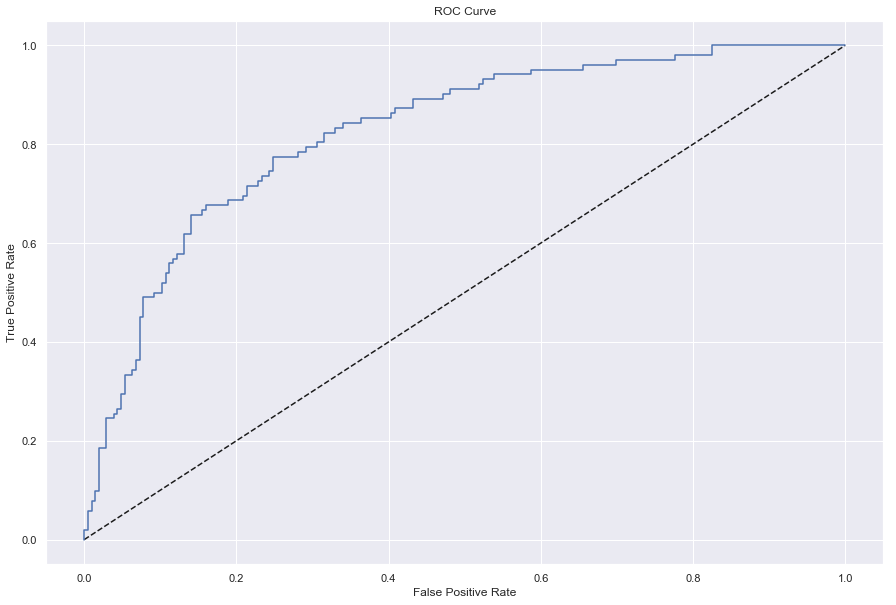

In [10]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

This ROC curve provides a nice visual way to assess your classifier's performance.

### Precision-recall Curve
When looking at your ROC curve, you may have noticed that the y-axis (True positive rate) is also known as recall. Indeed, in addition to the ROC curve, there are other ways to visually evaluate model performance. One such way is the **precision-recall curve**, which is generated by plotting the precision and recall for different thresholds. As a reminder, precision and recall are defined as:

$Precision=\frac{TP}{TP+FP}$

$Recall=\frac{TP}{TP+FN}$

A **precision-recall curve** has been generated for the diabetes dataset. 

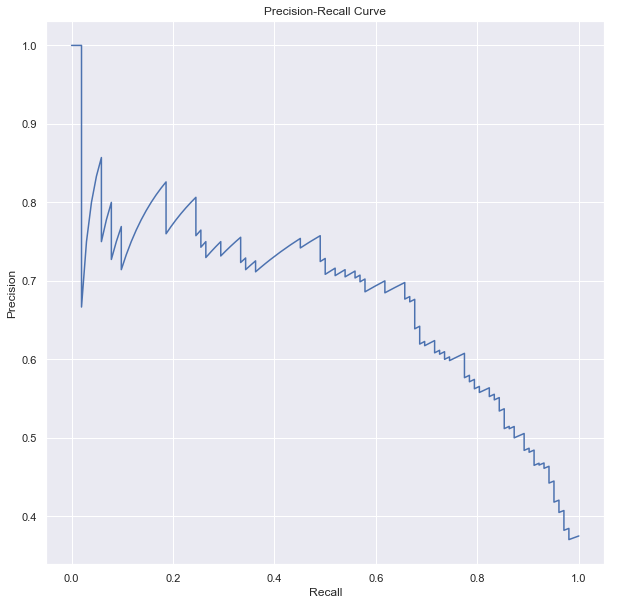

In [11]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate precision-recall curve values: fpr, tpr, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot precision-recall curve
plt.figure(figsize=(10,10))
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [12]:
# Compute and print the classification report and confusion matrix
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       206
           1       0.69      0.66      0.67       102

   micro avg       0.79      0.79      0.79       308
   macro avg       0.76      0.76      0.76       308
weighted avg       0.79      0.79      0.79       308

[[176  30]
 [ 35  67]]


Study the precision-recall curve and then consider the statements given below. Choose the one statement that is **not** true. Note that here, **the class is positive (1) if the individual has diabetes**.

**Possible Answers**
- [ ] A recall of 1 corresponds to a classifier with a low threshold in which all females who contract diabetes were correctly classified as such, at the expense of many misclassifications of those who did not have diabetes.
    > _This is actually a true statement! Observe how when the recall is high, the precision drops._
- [ ] Precision is undefined for a classifier which makes no positive predictions, that is, classifies everyone as not having diabetes.
    > _In the case when there are no true positives or true negatives, precision is 0/0, which is undefined._
- [ ] When the threshold is very close to 1, precision is also 1, because the classifier is absolutely certain about its predictions.
    > _This is a correct statement. Notice how a high precision corresponds to a low recall: The classifier has a high threshold to ensure the positive predictions it makes are correct, which means it may miss some positive labels that have lower probabilities._
- [x] Precision and recall take true negatives into consideration.
    > **True negatives do not appear at all in the definitions of precision and recall.**

## Area under the ROC curve (AUC)
- Larger area under the ROC curve = better model
- A True Positive Rate of one and a False Positive Rate of 0, This would be a great model!
    - For this reason, AUC is another popular metric for classification models.

![][AUC]

[AUC]: _Docs/AUC.png

In [13]:
%%HTML
<video style="display:block; margin: 0 auto;" controls>
      <source src="_Docs/03-Area_under_the_ROC_curve.mp4" type="video/mp4">
</video>

### AUC computation
Say you have a binary classifier that in fact is just randomly making guesses. It would be correct approximately 50% of the time, and the resulting ROC curve would be a diagonal line in which the True Positive Rate and False Positive Rate are always equal. The Area under this ROC curve would be 0.5. This is one way in which the AUC, which Hugo discussed in the video, is an informative metric to evaluate a model. **If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!**

In this exercise, you'll calculate AUC scores using the `roc_auc_score()` function from `sklearn.metrics` as well as by performing cross-validation on the diabetes dataset.

`X` and `y`, along with training and test sets `X_train`, `X_test`, `y_train`, `y_test`, have been pre-loaded for you, and a logistic regression classifier `logreg` has been fit to the training data.

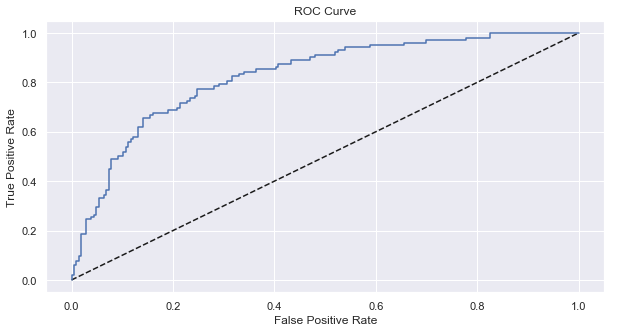

In [14]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [15]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.8255758614125261
AUC scores computed using 5-fold cross-validation: [0.80185185 0.80666667 0.81481481 0.86245283 0.8554717 ]


You now have a number of different methods you can use to evaluate your model's performance.

## Hyperparameter tuning

- Linear regression: Choosing parameters
- Ridge/lasso regression: Choosing alpha
- k-Nearest Neighbors: Choosing n_neighbors
- Parameters like alpha and k: Hyperparameters
- Hyperparameters cannot be learned by fitting the model

### Choosing the correct hyperparameter
- Try a bunch of different hyperparameter values
- Fit all of them separately
- See how well each performs
- Choose the best performing one
- It is essential to use cross-validation

### Grid search cross-validation
- For example, if we had two Hyperparameters, C and Alpha, we build a grid values to test.
    - Perform K-fold Cross Validation for each point in the grid (combination of Hyperparameters)    
    - Finally, choose the hyperparameters who perfomed the best for the model
- In Scikit-learn its implemented using the class GridSearchCV
![][GridSearchCV]

[GridSearchCV]: _Docs/GridSearchCV.gif

### Hyperparameter tuning with GridSearchCV
Hugo demonstrated how to tune the `n_neighbors` parameter of the `KNeighborsClassifier()` using `GridSearchCV` on the voting dataset. You will now practice this yourself, but by using logistic regression on the diabetes dataset instead!

Like the alpha parameter of lasso and ridge regularization that you saw earlier, logistic regression also has a regularization parameter: $C$. $C$ controls the *inverse* of the regularization strength, and this is what you will tune in this exercise. **A large $C$ can lead to an overfit model, while a small $C$ can lead to an underfit model.**

The hyperparameter space for $C$ has been setup for you. Your job is to use `GridSearchCV` and logistic regression to find the optimal $C$ in this hyperparameter space. The feature array is available as `X` and target variable array is available as `y`.

You may be wondering why you aren't asked to split the data into training and test sets. Good observation! Here, we want you to focus on the process of setting up the hyperparameter grid and performing grid-search cross-validation. In practice, you will indeed want to hold out a portion of your data for evaluation purposes, and you will learn all about this in the next video!

In [16]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
# solver='liblinear' to avoid FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
logreg = LogisticRegression(solver='liblinear')

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 3.727593720314938}
Best score is 0.7708333333333334


### Hyperparameter tuning with RandomizedSearchCV
**`GridSearchCV` can be computationally expensive, especially if you are searching over a large hyperparameter space and dealing with multiple hyperparameters**. A solution to this is to use `RandomizedSearchCV`, in which not all hyperparameter values are tried out. Instead, a fixed number of hyperparameter settings is sampled from specified probability distributions. You'll practice using `RandomizedSearchCV` in this exercise and see how this works.

Here, you'll also be introduced to a new model: the [Decision Tree][1]. Don't worry about the specifics of how this model works. Just like k-NN, linear regression, and logistic regression, decision trees in scikit-learn have .fit() and .predict() methods that you can use in exactly the same way as before. Decision trees have many parameters that can be tuned, such as `max_features`, `max_depth`, and `min_samples_leaf`: This makes it an ideal use case for `RandomizedSearchCV`.

As before, the feature array `X` and target variable array `y` of the diabetes dataset have been pre-loaded. The hyperparameter settings have been specified for you. Your goal is to use `RandomizedSearchCV` to find the optimal hyperparameters. Go for it!

[1]: https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

In [17]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 5}
Best score is 0.734375


You'll see a lot more of decision trees and `RandomizedSearchCV` as you continue your machine learning journey. **Note that `RandomizedSearchCV` will never outperform `GridSearchCV`. Instead, it is valuable because it saves on computation time.**

## Hold-out set for final evaluation
- How well can the model perform on never before seen data?
- Using ALL data for cross-validation is not ideal
- Split data into training and hold-out set at the beginning
- Perform grid search cross-validation on training set
- Choose best hyperparameters and evaluate on hold-out set

In [18]:
%%HTML
<video style="display:block; margin: 0 auto;" controls>
      <source src="_Docs/05-Hold-out_set_for_final_evaluation.mp4" type="video/mp4">
</video>

### Hold-out set reasoning
For which of the following reasons would you want to use a hold-out set for the very end?

**Answer the question**
- [ ] You want to maximize the amount of training data used.
- [x] You want to be absolutely certain about your model's ability to generalize to unseen data.
    > **The idea is to tune the model's hyperparameters on the training set, and then evaluate its performance on the hold-out set which it has never seen before.**
- [ ] You want to tune the hyperparameters of your model.

### Hold-out set in practice I: Classification
You will now practice evaluating a model with tuned hyperparameters on a hold-out set. The feature array and target variable array from the diabetes dataset have been pre-loaded as `X` and `y`.

In addition to $C$, logistic regression has a `'penalty'` hyperparameter which specifies whether to use `'l1'` or `'l2'` regularization. Your job in this exercise is to create a hold-out set, tune the `'C'` and `'penalty'` hyperparameters of a logistic regression classifier using `GridSearchCV` on the training set.

In [19]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(solver='liblinear')

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 0.4393970560760795, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.7652173913043478


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Hold-out set in practice II: Regression
Remember lasso and ridge regression from the previous chapter? Lasso used the $L1$ penalty to regularize, while ridge used the $L2$ penalty. There is another type of regularized regression known as the **[elastic net][1]**. In [elastic net][2] regularization, the penalty term is a linear combination of the $L1$ and $L2$ penalties:

$a∗L1+b∗L2$

In scikit-learn, this term is represented by the `'l1_ratio'` parameter: An `'l1_ratio'` of 1 corresponds to an $L1$ penalty, and anything lower is a combination of $L1$ and $L2$.

In this exercise, you will `GridSearchCV` to tune the `'l1_ratio'` of an [elastic net][3] model trained on the Gapminder data. As in the previous exercise, use a hold-out set to evaluate your model's performance.

[1]: https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net
[2]: https://towardsdatascience.com/regression-analysis-lasso-ridge-and-elastic-net-9e65dc61d6d3
[3]: https://medium.com/@jayeshbahire/lasso-ridge-and-elastic-net-regularization-4807897cb722

In [20]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv('../_datasets/gm_2008_region.csv')
df = df.drop(['Region'], axis=1)

# Using all features
X = df.drop(['life'], axis=1).values

# Target Value
y = df.life.values

df.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4
3,2975029.0,1.40,0.1,1.804106,25.35542,7383.0,132.8108,72.5,20.0
4,21370348.0,1.96,0.1,18.016313,27.56373,41312.0,117.3755,81.5,5.2


In [21]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.20689655172413793}
Tuned ElasticNet R squared: 0.8668305372460283
Tuned ElasticNet MSE: 10.057914133398441


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Now that you understand how to fine-tune your models, it's time to learn about preprocessing techniques and how to piece together all the different stages of the machine learning process into a pipeline!